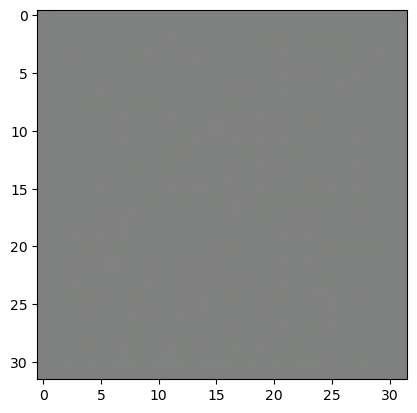

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=2)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=2)
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=2)
        self.norm3 = nn.BatchNorm2d(128)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3200, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.flatten(x)
        x = F.dropout(x, 0.5)
        x = self.linear1(x)
        x = F.sigmoid(x)
        return x


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(64, 64 * 4 * 4)
        self.conv1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 3, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        x = self.linear1(x)
        x = x.view(-1, 64, 4, 4)
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv4(x)
        x = torch.tanh(x)
        return x


discriminator = Discriminator().to(device)
generator = Generator().to(device)

lrd = 0.00001
lrg = 0.000015
betas = (0.5, 0.999)

discriminator_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=lrd, betas=betas
)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=lrg, betas=betas)

# test_vectors = torch.randn(25, 64, device=device)
# torch.save(test_vectors, 'test_vectors.pt')
test_vectors = torch.load("test_vectors.pt")

y = generator.forward(torch.randn(64, device=device))
plt.imshow(y[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)
plt.imsave("noise.png", y[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)

# Load dataset

In [19]:
import os
from torchvision import transforms


def load_dataset():
    transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            lambda x: x * 2 - 1,
        ]
    )

    true_images = []
    for f in os.listdir("crawled_cakes"):
        img = Image.open(os.path.join("crawled_cakes", f))
        img = transform(img)
        true_images.append(img)

    true_images = torch.stack(true_images)
    true_images_dataset = true_images.to(device)
    return true_images_dataset


true_images_dataset = load_dataset()

train_loader = torch.utils.data.DataLoader(
    true_images_dataset, batch_size=16, shuffle=True
)

In [20]:
len(true_images_dataset)

975

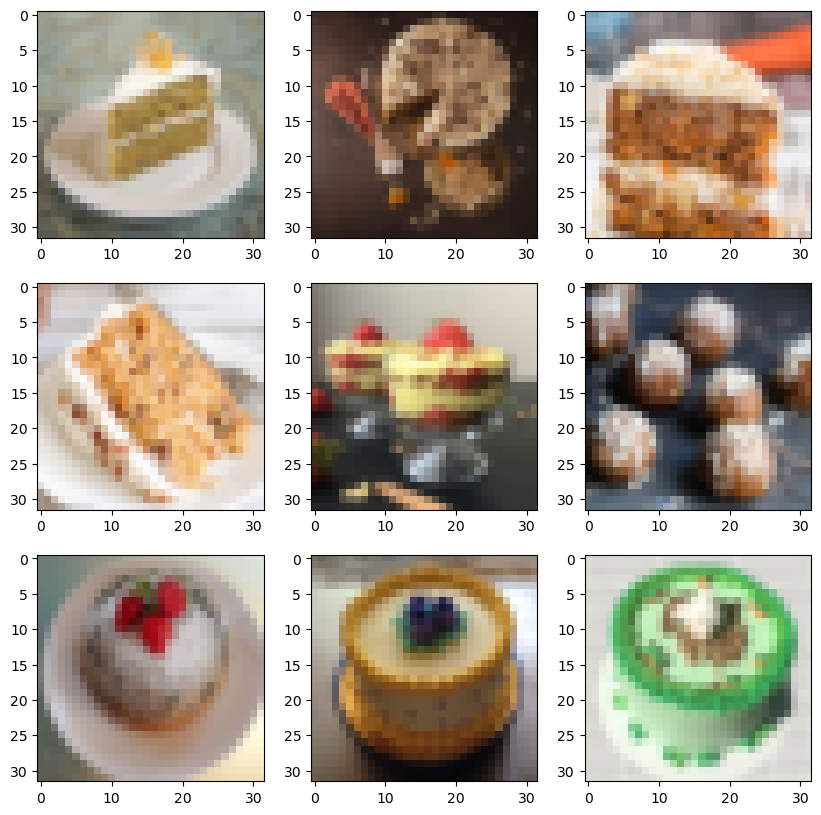

In [16]:
# plot 9 images
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(
            true_images_dataset[i * 3 + j].cpu().detach().numpy().transpose(1, 2, 0)
            / 2
            + 0.5
        )
fig.savefig("true_images_sample.png")

In [3]:
class Minimodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(2, 2)
        self.lin2 = nn.Linear(2, 2)

    def forward(self, x):
        x = self.lin(x)
        x = self.lin2(x)
        return x


minimodel = Minimodel()
input_val = torch.randn(10, 2)
loss_fn = lambda x: ((x - 42) ** 2).sum()
optimizer = torch.optim.SGD(minimodel.lin.parameters(), lr=0.01)

# for i in range(20):
#     optimizer.zero_grad()
#     pred = minimodel(input_val)
#     loss = loss_fn(pred)

#     loss.backward()

#     optimizer.step()

#     print(pred)
#     print("Loss:", loss.item())

In [25]:
starting_epoch = 2000
path = f"models_4/epoch_{starting_epoch}"
# load model

generator.load_state_dict(torch.load(os.path.join(path, "generator.pt")))
discriminator.load_state_dict(torch.load(os.path.join(path, "discriminator.pt")))
generator_optimizer.load_state_dict(
    torch.load(os.path.join(path, "generator_optimizer.pt"))
)
discriminator_optimizer.load_state_dict(
    torch.load(os.path.join(path, "discriminator_optimizer.pt"))
)


In [10]:
def monitor_and_save(epoch, discriminator_losses, generator_losses, modelpath="models"):
    path = f"{modelpath}/epoch_{epoch}"
    os.makedirs(path, exist_ok=True)
    os.makedirs(f"{modelpath}/images", exist_ok=True)
    torch.save(generator.state_dict(), os.path.join(path, "generator.pt"))
    torch.save(discriminator.state_dict(), os.path.join(path, "discriminator.pt"))
    torch.save(
        generator_optimizer.state_dict(), os.path.join(path, "generator_optimizer.pt")
    )
    torch.save(
        discriminator_optimizer.state_dict(),
        os.path.join(path, "discriminator_optimizer.pt"),
    )

    generated_images = generator.forward(test_vectors)
    fig, ax = plt.subplots(5, 5, figsize=(10, 10))
    for i in range(5):
        for j in range(5):
            ax[i, j].imshow(
                generated_images[i * 5 + j].cpu().detach().numpy().transpose(1, 2, 0)
                / 2
                + 0.5
            )
            ax[i, j].axis("off")

    plt.savefig(os.path.join(path, "generated_images.png"))
    plt.savefig(f"{modelpath}/images/epoch_{epoch}.png")
    plt.close()

    with open(os.path.join(path, "losses.txt"), "w") as f:
        f.write(str(discriminator_losses))
        f.write("\n")
        f.write(str(generator_losses))
        f.write("\n")

In [11]:
for epoch in range(10000):
    print(f"Epoch {epoch}")
    disc_losses = []
    gen_losses = []
    for ib, image_batch in enumerate(train_loader):
        # train discriminator on true images
        discriminator_optimizer.zero_grad()
        pred1 = discriminator(image_batch)
        target = torch.ones((pred1.shape[0], 1), device=device)
        loss1 = F.binary_cross_entropy(pred1, target)
        loss1.backward()

        # train discriminator on generated images
        pred2 = discriminator.forward(
            generator.forward(torch.randn(16, 64, device=device))
        )
        target = torch.zeros((pred2.shape[0], 1), device=device)
        loss2 = F.binary_cross_entropy(pred2, target)
        loss2.backward()

        discriminator_optimizer.step()
        disc_losses.append((loss1 + loss2).item()/2)

        # train generator
        generator_optimizer.zero_grad()
        batch = generator.forward(torch.randn(16, 64, device=device))
        pred = discriminator(batch)
        target = torch.ones((pred.shape[0], 1), device=device)
        loss = F.binary_cross_entropy(pred, target)
        loss.backward()
        generator_optimizer.step()
        gen_losses.append(loss.item())

    mean_disc_loss = sum(disc_losses) / len(disc_losses)
    mean_gen_loss = sum(gen_losses) / len(gen_losses)
    print("Discriminator loss: %.7f" % mean_disc_loss)
    print("Generator loss: %.7f" % mean_gen_loss)

    if (
        epoch < 10
        and epoch % 1 == 0
        or epoch < 100
        and epoch % 10 == 0
        or epoch % 20 == 0
    ):
        monitor_and_save(epoch, mean_disc_loss, mean_gen_loss, modelpath="models_4")

Epoch 0
Discriminator loss: 0.8265767
Generator loss: 0.6323583
Epoch 1
Discriminator loss: 0.9102627
Generator loss: 0.4611350
Epoch 2
Discriminator loss: 1.0506367
Generator loss: 0.3515011
Epoch 3
Discriminator loss: 1.0499009
Generator loss: 0.4051754
Epoch 4
Discriminator loss: 1.0540205
Generator loss: 0.3923909
Epoch 5
Discriminator loss: 1.0013194
Generator loss: 0.4507390
Epoch 6
Discriminator loss: 1.0141513
Generator loss: 0.4487184
Epoch 7
Discriminator loss: 0.9680010
Generator loss: 0.5043141
Epoch 8
Discriminator loss: 0.8979461
Generator loss: 0.5600026
Epoch 9
Discriminator loss: 0.9051708
Generator loss: 0.5533207
Epoch 10
Discriminator loss: 0.8582417
Generator loss: 0.6258733
Epoch 11
Discriminator loss: 0.8399488
Generator loss: 0.6166945
Epoch 12
Discriminator loss: 0.8339566
Generator loss: 0.6024435
Epoch 13
Discriminator loss: 0.7642873
Generator loss: 0.7403959
Epoch 14
Discriminator loss: 0.7746477
Generator loss: 0.6719563
Epoch 15
Discriminator loss: 0.7047

KeyboardInterrupt: 

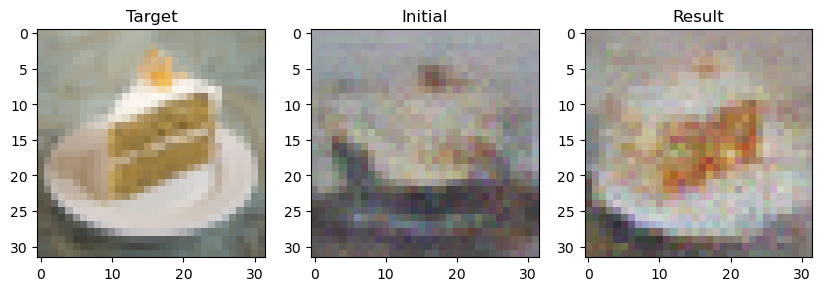

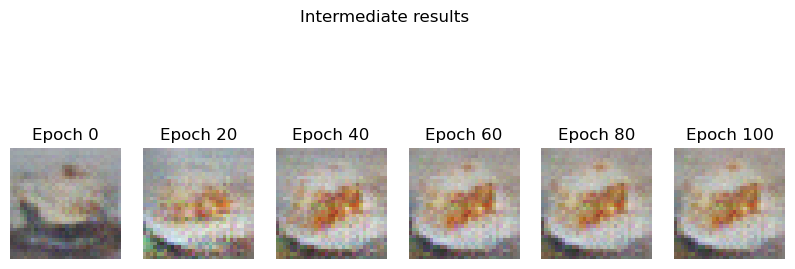

In [128]:
input_vector = torch.randn(1, 64, device=device, requires_grad=True)
target_image = true_images_dataset[0]
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(target_image.cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)

result = generator.forward(input_vector)

ax[1].imshow(result[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)

image_optim = torch.optim.SGD([input_vector], lr=0.01, momentum=0.9)
loss_fn = lambda x: ((x - target_image) ** 2).sum()

intermediate_results = []
for i in range(101):
    if i % 20 == 0:
        intermediate_results.append(
            result[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5
        )
    image_optim.zero_grad()
    result = generator.forward(input_vector)
    loss = loss_fn(result)
    loss.backward()
    image_optim.step()


ax[2].imshow(result[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)

ax[0].title.set_text("Target")
ax[1].title.set_text("Initial")
ax[2].title.set_text("Result")

fig.savefig("target_initial_result.png")

fig, ax = plt.subplots(1, 6, figsize=(10, 4))
for i in range(6):
    ax[i].imshow(intermediate_results[i])
    ax[i].title.set_text(f"Epoch {i*20}")
    ax[i].axis("off")
fig.suptitle("Intermediate results")
fig.savefig("intermediate_results.png")


def fit_input_vector(input_vector, target):
    input_vector = input_vector.clone().detach().requires_grad_(True)
    image_optim = torch.optim.SGD([input_vector], lr=0.01, momentum=0.9)
    loss_fn = lambda x: ((x - target) ** 2).sum()
    intermediate_results = []
    for i in range(101):
        image_optim.zero_grad()
        result = generator.forward(input_vector)
        loss = loss_fn(result)
        loss.backward()
        image_optim.step()
        if i % 20 == 0:
            intermediate_results.append(result[0].cpu().detach())
    return input_vector, intermediate_results

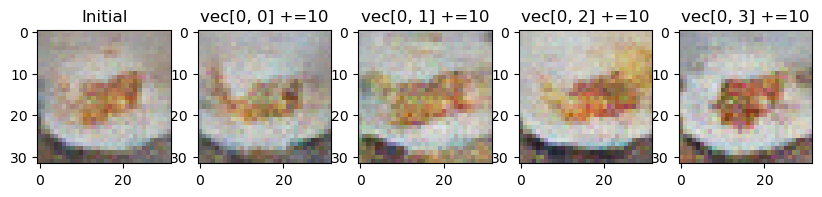

In [107]:
vector2 = input_vector.clone().detach()
vector3 = input_vector.clone().detach()
vector4 = input_vector.clone().detach()
vector5 = input_vector.clone().detach()

vector2[0, 0] += 10
result2 = generator.forward(vector2)

vector3[0, 1] += 10
result3 = generator.forward(vector3)

vector4[0, 2] += 10
result4 = generator.forward(vector4)

vector5[0, 3] += 10
result5 = generator.forward(vector5)


fig, ax = plt.subplots(1, 5, figsize=(10, 4))
ax[0].imshow(result[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)
ax[1].imshow(result2[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)
ax[2].imshow(result3[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)
ax[3].imshow(result4[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)
ax[4].imshow(result5[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)
ax[0].title.set_text("Initial")
ax[1].title.set_text("vec[0, 0] +=10")
ax[2].title.set_text("vec[0, 1] +=10")
ax[3].title.set_text("vec[0, 2] +=10")
ax[4].title.set_text("vec[0, 3] +=10")


fig.savefig("changing_parameters.png")

In [116]:
from PIL import Image
input_vector = torch.randn(1, 64, device=device, requires_grad=True)

target_image = Image.open("cat.jpg")
target_image = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        lambda x: x * 2 - 1,
    ]
)(target_image)
target_image = target_image.to(device)



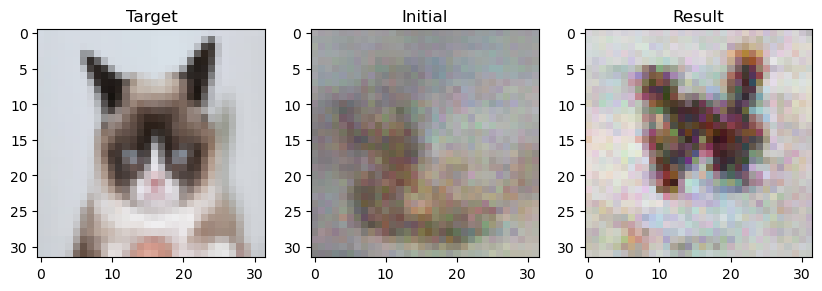

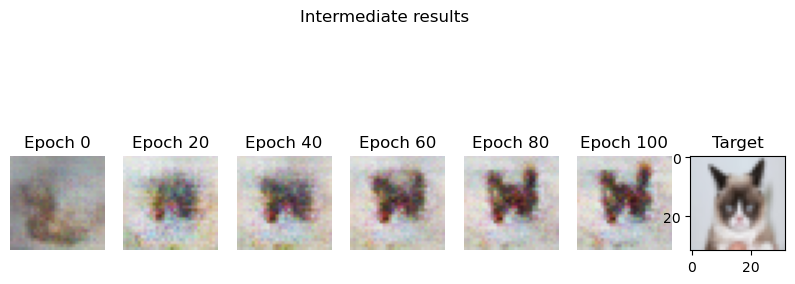

In [118]:
input_vector = torch.randn(1, 64, device=device, requires_grad=True)
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(
    target_image.cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5
)

result = generator.forward(input_vector)

ax[1].imshow(
    result[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5
)

image_optim = torch.optim.SGD([input_vector], lr=0.01, momentum=0.9)
loss_fn = lambda x: ((x - target_image) ** 2).sum()

intermediate_results = []
for i in range(101):
    if i % 20 == 0:
        intermediate_results.append(result[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)
    image_optim.zero_grad()
    result = generator.forward(input_vector)
    loss = loss_fn(result)
    loss.backward()
    image_optim.step()



ax[2].imshow(
    result[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5
)

ax[0].title.set_text("Target")
ax[1].title.set_text("Initial")
ax[2].title.set_text("Result")

fig.savefig("target_initial_result.png")

fig, ax = plt.subplots(1, 7, figsize=(10, 4))
for i in range(6):
    ax[i].imshow(
        intermediate_results[i]
    )
    ax[i].title.set_text(f"Epoch {i*20}")
    ax[i].axis("off")
ax[6].imshow(target_image.cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)
ax[6].title.set_text("Target")
fig.suptitle("Intermediate results")
fig.savefig("intermediate_results.png")




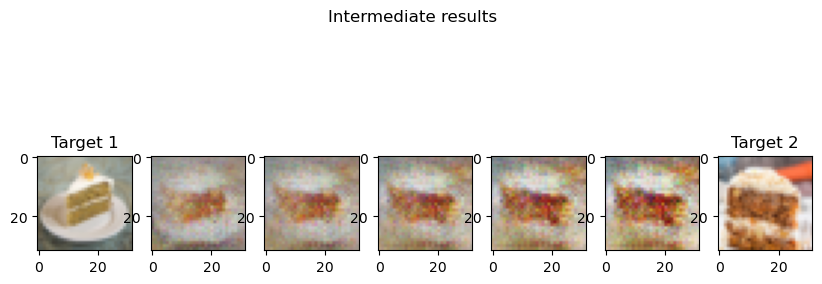

In [139]:
#show input vector result

target_image_1 = true_images_dataset[0]
target_image_2 = true_images_dataset[2]

input_vector_0 = torch.randn(1, 64, device=device, requires_grad=True)
ivec1, _ = fit_input_vector(input_vector, target_image_1)
ivec2, _ = fit_input_vector(ivec1, target_image_2)

diff = ivec2 - ivec1
int_size = 5
intermediate_vectors = []
for i in range(int_size):
    intermediate_vectors.append(ivec1 + diff * (i+1) / int_size)

intermediates = []
for ivec in intermediate_vectors:
    result = generator.forward(ivec)
    intermediates.append(result[0].cpu().detach())




int_img_size = len(intermediates)
fig, ax = plt.subplots(1, int_img_size+2, figsize=(10, 4))
ax[0].imshow(target_image_1.cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)
for i in range(1, int_img_size+1):
    ax[i].imshow(intermediates[i-1].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)
ax[-1].imshow(target_image_2.cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)
ax[0].title.set_text("Target 1")
ax[-1].title.set_text("Target 2")
fig.suptitle("Intermediate results")

fig.savefig("intermediate_results_2.png")
